# Évaluation Sommative — Pipeline de détection de fraude 

## Objectif
Construire un pipeline **reproductible** de préparation des données et d'entraînement de modèles pour la **détection de fraude** (dataset `creditcard.csv`).

Ce notebook met l’accent sur :
- **Anti-fuite de données (data leakage)** : split train/test *avant* toutes transformations.
- **Feature engineering “métier”** : capter des comportements typiques de fraude (tests à petit montant, achats très élevés).
- **Transformations** : traiter l’asymétrie et les outliers.
- **Déséquilibre de classes** : comparaison **baseline**, **class_weight**, **under-sampling**, **SMOTE**.
- **Choix du seuil** : ajuster le seuil de décision selon l’objectif (precision vs recall).

> **Note** : Les variables `V1..V28` proviennent d’une PCA. Elles contiennent beaucoup d’information, mais une logique métier sur `Amount` et le temps peut encore apporter un signal explicite.

In [1]:

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve

RANDOM_STATE = 42

## 1) Chargement des données



- `Class` : 0 = normal, 1 = fraude (classe rare).
- `Time` : secondes depuis la première transaction enregistrée.
- `V1..V28` : variables issues d’une PCA (déjà centrées/transformées).
- `Amount` : montant de la transaction .

In [2]:

df = pd.read_csv("creditcard.csv")
print("Shape:", df.shape)
df.head()

Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## 2) Déséquilibre de la cible

Dans ce dataset, la fraude est très rare.  
 Les métriques comme **Accuracy** sont trompeuses ; on suit surtout :
- **PR-AUC (Average Precision)** : très informative en classe rare
- **Recall** sur la classe 1 : combien de fraudes on attrape
- **Precision** sur la classe 1 : combien d’alertes sont vraies

Class
0    284315
1       492
Name: count, dtype: int64
Fraud rate (%): 0.1727


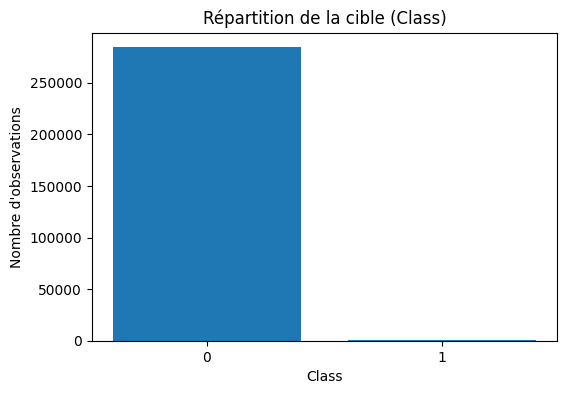

In [4]:

counts = df["Class"].value_counts()
fraud_rate = df["Class"].mean() * 100

print(counts)
print(f"Fraud rate (%): {fraud_rate:.4f}")

plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Répartition de la cible (Class)")
plt.xlabel("Class")
plt.ylabel("Nombre d'observations")
plt.show()

## 3) Visualisations “métier”

### 3.1 Montant : Normal vs Fraude (échelle log)
On observe souvent :
- beaucoup de fraudes sur de **petits montants** (transactions “test”)
- et/ou une remontée sur de **très gros montants**

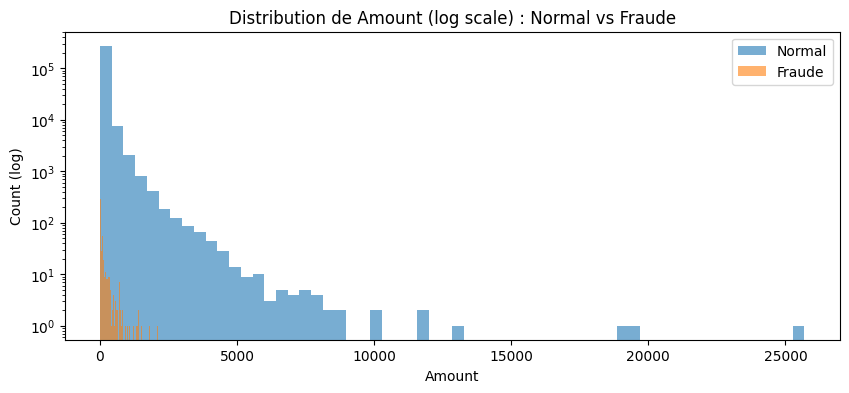

In [5]:

plt.figure(figsize=(10,4))
plt.hist(df[df["Class"]==0]["Amount"], bins=60, alpha=0.6, label="Normal")
plt.hist(df[df["Class"]==1]["Amount"], bins=60, alpha=0.6, label="Fraude")
plt.yscale("log")
plt.title("Distribution de Amount (log scale) : Normal vs Fraude")
plt.xlabel("Amount")
plt.ylabel("Count (log)")
plt.legend()
plt.show()

### 3.2 Taux de fraude par déciles de montant
Un histogramme montre des **comptages**.  
Ici, on veut un **risque** : `P(Fraude | tranche de montant)`.

Si la courbe est en **U** (forte en bas et en haut), cela justifie des features qui captent **les extrêmes**.

/tmp/ipykernel_3048/2586396083.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_decile = df_tmp.groupby("amount_decile")["Class"].mean()


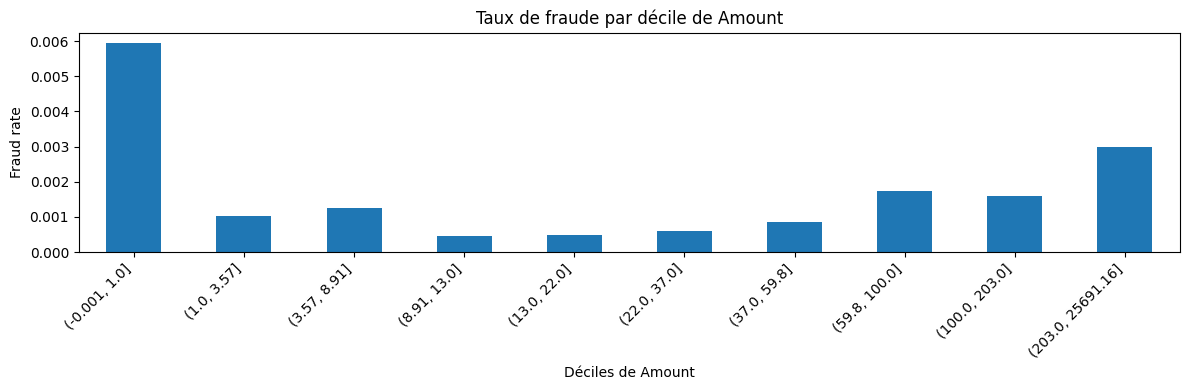

In [6]:

df_tmp = df.copy()
df_tmp["amount_decile"] = pd.qcut(df_tmp["Amount"], q=10, duplicates="drop")
fraud_rate_by_decile = df_tmp.groupby("amount_decile")["Class"].mean()

plt.figure(figsize=(12,4))
fraud_rate_by_decile.plot(kind="bar")
plt.title("Taux de fraude par décile de Amount")
plt.xlabel("Déciles de Amount")
plt.ylabel("Fraud rate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

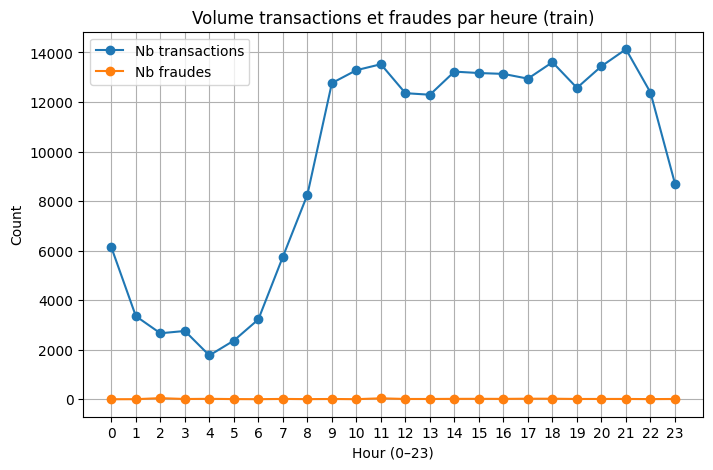

In [20]:
tmp = pd.DataFrame({
    "Hour": ((X_train["Time"] // 3600) % 24).astype(int),
    "Class": y_train.values
})

counts = tmp.groupby("Hour")["Class"].size()
frauds = tmp.groupby("Hour")["Class"].sum()

plt.figure(figsize=(8,5))
plt.plot(counts.index, counts.values, marker="o", label="Nb transactions")
plt.plot(frauds.index, frauds.values, marker="o", label="Nb fraudes")
plt.xticks(range(0,24))
plt.xlabel("Hour (0–23)")
plt.ylabel("Count")
plt.title("Volume transactions et fraudes par heure (train)")
plt.legend()
plt.grid(True)
plt.show()


## 4) Split Train/Test (anti-fuite de données)

  On fait le split **avant** :
- feature engineering,
- scalers,
- transformations (PowerTransformer),
- rééchantillonnage (SMOTE / under-sampling).

Sinon, on “apprend” des informations du test.

In [7]:

X = df.drop(columns=["Class"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Fraud rate train:", y_train.mean(), "Fraud rate test:", y_test.mean())

Train: (227845, 30) Test: (56962, 30)
Fraud rate train: 0.001729245759178389 Fraud rate test: 0.0017204452090867595


## 5) Feature engineering (logique métier)

On ajoute :
1) **Hour** : heure de la journée (0..23) extraite de `Time`  
2) **Extrêmes de montant** :
   - `is_very_small_amount` : 1 si Amount < **Q10 (train)**
   - `is_very_large_amount` : 1 si Amount > **Q90 (train)**

Pourquoi Q10 et Q90 ?
- Le graphique des déciles montre souvent un risque plus fort aux **extrêmes**.
- Q10/Q90 sont **adaptatifs** au dataset (pas un seuil arbitraire).
- Les quantiles sont calculés **sur train uniquement** ➜ pas de fuite de données.

> On gardera ensuite `scaled_amount` (montant transformé et robust-scalé), et on supprimera `Amount` brut.

In [8]:

# Seuils calculés sur le TRAIN uniquement (anti leakage)
q10 = X_train["Amount"].quantile(0.10)
q90 = X_train["Amount"].quantile(0.90)
print("Q10 train:", q10)
print("Q90 train:", q90)

def add_features(df_in: pd.DataFrame, q10_thr: float, q90_thr: float) -> pd.DataFrame:
    df_ = df_in.copy()
    df_["Hour"] = (df_["Time"] // 3600) % 24
    df_["is_very_small_amount"] = (df_["Amount"] < q10_thr).astype(int)
    df_["is_very_large_amount"] = (df_["Amount"] > q90_thr).astype(int)
    return df_

X_train_fe = add_features(X_train, q10, q90)
X_test_fe  = add_features(X_test,  q10, q90)

# Petite validation "métier" : taux de fraude selon ces flags (sur TRAIN)
tmp = pd.DataFrame({
    "is_very_small_amount": X_train_fe["is_very_small_amount"],
    "is_very_large_amount": X_train_fe["is_very_large_amount"],
    "Class": y_train.values
})
print("Fraud rate (train) selon is_very_small_amount:")
print(tmp.groupby("is_very_small_amount")["Class"].mean())
print("\nFraud rate (train) selon is_very_large_amount:")
print(tmp.groupby("is_very_large_amount")["Class"].mean())

Q10 train: 1.0
Q90 train: 203.95
Fraud rate (train) selon is_very_small_amount:
is_very_small_amount
0    0.001567
1    0.004324
Name: Class, dtype: float64

Fraud rate (train) selon is_very_large_amount:
is_very_large_amount
0    0.001585
1    0.003028
Name: Class, dtype: float64


## 6) Transformations (train uniquement)

### 6.1 Montant
- `Amount` est très asymétrique ➜ on applique `log1p(Amount)` pour “compresser” les grosses valeurs.
- puis `RobustScaler` (médiane + IQR) pour être **robuste aux outliers**.

### 6.2 Time
Même si on a `Hour`, la variable `Time` peut porter une information de **période** (début/fin de capture).  
On la met aussi à l’échelle via `RobustScaler`.

### 6.3 Certaines composantes PCA (V*)
Même si les `V*` viennent d’une PCA, certaines peuvent rester asymétriques.  
On applique sur un sous-ensemble une transformation **Yeo-Johnson** (compatible avec valeurs négatives) :
- fit sur train
- transform train et test avec les mêmes paramètres

In [9]:

V_TO_TRANSFORM = ["V28","V21","V7","V6","V10","V27","V20","V8","V23","V12"]
print("V_TO_TRANSFORM:", V_TO_TRANSFORM)

# Copie pour éviter des effets de bord
X_train_fe = X_train_fe.copy()
X_test_fe  = X_test_fe.copy()

# 6.1 Log sur Amount
X_train_fe["Amount_log"] = np.log1p(X_train_fe["Amount"])
X_test_fe["Amount_log"]  = np.log1p(X_test_fe["Amount"])

# 6.1 RobustScaler sur Amount_log
sc_amount = RobustScaler()
sc_amount.fit(X_train_fe[["Amount_log"]])

X_train_fe["scaled_amount"] = sc_amount.transform(X_train_fe[["Amount_log"]]).ravel()
X_test_fe["scaled_amount"]  = sc_amount.transform(X_test_fe[["Amount_log"]]).ravel()

# 6.2 RobustScaler sur Time
sc_time = RobustScaler()
sc_time.fit(X_train_fe[["Time"]])

X_train_fe["scaled_time"] = sc_time.transform(X_train_fe[["Time"]]).ravel()
X_test_fe["scaled_time"]  = sc_time.transform(X_test_fe[["Time"]]).ravel()

# 6.3 Yeo-Johnson sur V sélectionnées
pt = PowerTransformer(method="yeo-johnson")
pt.fit(X_train_fe[V_TO_TRANSFORM])

X_train_fe[V_TO_TRANSFORM] = pt.transform(X_train_fe[V_TO_TRANSFORM])
X_test_fe[V_TO_TRANSFORM]  = pt.transform(X_test_fe[V_TO_TRANSFORM])

# Colonnes brutes supprimées (redondantes après transformation)
DROP_COLS = ["Time", "Amount", "Amount_log"]
X_train_ready = X_train_fe.drop(columns=DROP_COLS)
X_test_ready  = X_test_fe.drop(columns=DROP_COLS)

print("Train ready:", X_train_ready.shape)
print("Test ready :", X_test_ready.shape)
X_train_ready.head()

V_TO_TRANSFORM: ['V28', 'V21', 'V7', 'V6', 'V10', 'V27', 'V20', 'V8', 'V23', 'V12']
Train ready: (227845, 33)
Test ready : (56962, 33)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Hour,is_very_small_amount,is_very_large_amount,scaled_amount,scaled_time
265518,1.946747,-0.752526,-1.355130,-0.661630,1.502822,2.530347,-1.195983,1.193358,1.406819,-0.106992,...,0.690980,-0.350316,-0.388907,0.182260,-0.090864,20.0,0,0,-0.411696,0.905774
180305,2.035149,-0.048880,-3.058693,0.247945,2.943487,2.157106,-0.000786,0.641573,0.045826,0.304136,...,0.707090,0.512885,-0.471198,-0.005501,-0.205597,10.0,0,0,-0.709232,0.465984
42664,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.414925,-1.789942,-3.636030,0.000772,-2.010828,...,-0.932803,0.826684,0.913773,0.083143,0.579844,11.0,0,0,0.824159,-0.512286
198723,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.179880,-1.154125,-0.068541,-1.118447,1.564049,...,-0.538236,-0.278032,-0.162068,0.033199,-0.186850,12.0,0,0,-0.475897,0.561678
82325,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.008022,0.407953,-0.188334,-0.044782,-0.498444,...,-1.362383,-0.292234,-0.144622,-0.092790,-0.190564,16.0,0,0,0.539125,-0.298886


## 7) Fonction d’évaluation (ROC-AUC + PR-AUC + matrice de confusion)

- **ROC-AUC** : utile mais peut être optimiste en classe très rare.
- **PR-AUC (Average Precision)** : plus représentatif en fraude.

In [10]:

def eval_model(name: str, model, X_test: pd.DataFrame, y_test: pd.Series) -> dict:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    roc = roc_auc_score(y_test, y_proba)
    pr = average_precision_score(y_test, y_proba)

    print("="*80)
    print(name)
    print("ROC-AUC :", round(roc, 4))
    print("PR-AUC  :", round(pr, 4))
    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)

    return {"name": name, "roc_auc": roc, "pr_auc": pr}

In [11]:
# --- Courbes ROC & Precision-Recall (PR) ---
# En fraude (classe rare), la PR curve est souvent plus informative que la ROC curve.
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

def plot_roc_pr_curves(
    model,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    label: str = "Model",
    threshold: float | None = None,
    show: bool = True,
    save_prefix: str | None = None
):
    """Trace ROC + PR curves à partir des probabilités du modèle.

    Notes:
    - ROC-AUC et PR-AUC (Average Precision) sont indépendants du seuil.
    - Si `threshold` est fourni, on place un point sur les courbes au seuil choisi.
    - `save_prefix` (optionnel) permet de sauvegarder en PNG : f"{save_prefix}_roc.png" et f"{save_prefix}_pr.png"
    """
    y_proba = model.predict_proba(X_test)[:, 1]

    # --- ROC ---
    fpr, tpr, thr_roc = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.4f})")
    plt.plot([0,1], [0,1], linestyle="--")
    if threshold is not None:
        idx = np.argmin(np.abs(thr_roc - threshold))
        plt.scatter(fpr[idx], tpr[idx], s=80, label=f"Seuil={threshold}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {label}")
    plt.legend()
    plt.grid(True)
    if save_prefix:
        plt.savefig(f"{save_prefix}_roc.png", dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

    # --- PR ---
    precision, recall, thr_pr = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)

    plt.figure(figsize=(7,5))
    plt.plot(recall, precision, label=f"{label} (AP={ap:.4f})")
    if threshold is not None and len(thr_pr) > 0:
        # thr_pr a longueur n-1 ; precision/recall ont n points
        idx2 = np.argmin(np.abs(thr_pr - threshold))
        plt.scatter(recall[idx2], precision[idx2], s=80, label=f"Seuil={threshold}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve — {label}")
    plt.legend()
    plt.grid(True)
    if save_prefix:
        plt.savefig(f"{save_prefix}_pr.png", dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

    print(f"{label} | ROC-AUC={roc_auc:.4f} | PR-AUC(AP)={ap:.4f}")

def plot_compare_models_roc_pr(
    models: dict,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    title_suffix: str = "",
    show: bool = True,
    save_prefix: str | None = None
):
    """Compare plusieurs modèles sur un même graphe ROC et PR.

    models: dict {"name": fitted_model}
    """
    # ROC
    plt.figure(figsize=(7,5))
    plt.plot([0,1], [0,1], linestyle="--")
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.4f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — Comparison {title_suffix}".strip())
    plt.legend()
    plt.grid(True)
    if save_prefix:
        plt.savefig(f"{save_prefix}_roc_compare.png", dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

    # PR
    plt.figure(figsize=(7,5))
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        ap = average_precision_score(y_test, y_proba)
        plt.plot(recall, precision, label=f"{name} (AP={ap:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve — Comparison {title_suffix}".strip())
    plt.legend()
    plt.grid(True)
    if save_prefix:
        plt.savefig(f"{save_prefix}_pr_compare.png", dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

## 8) Modèles testés (Logistic Regression) + gestion du déséquilibre

On compare 4 stratégies :

1) **Baseline** : entraînement sur train tel quel  
2) **class_weight='balanced'** : pénalise plus les erreurs sur la classe 1  
3) **Under-sampling** : réduit la classe majoritaire (plus rapide, mais perd de l’information)  
4) **SMOTE** : sur-échantillonnage synthétique de la classe minoritaire (attention au surapprentissage)

> Pour rester comparable, on évalue **toujours sur le même test** (non rééchantillonné).

In [12]:

results = []

# 8.1 Baseline
clf_base = LogisticRegression(max_iter=2000, solver="lbfgs", random_state=RANDOM_STATE)
clf_base.fit(X_train_ready, y_train)
results.append(eval_model("Baseline (no resampling)", clf_base, X_test_ready, y_test))

# 8.2 class_weight=balanced
clf_bal = LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced", random_state=RANDOM_STATE)
clf_bal.fit(X_train_ready, y_train)
results.append(eval_model("LogReg + class_weight=balanced", clf_bal, X_test_ready, y_test))

# 8.3 RandomUnderSampler
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_rus, y_rus = rus.fit_resample(X_train_ready, y_train)

clf_rus = LogisticRegression(max_iter=2000, solver="lbfgs", random_state=RANDOM_STATE)
clf_rus.fit(X_rus, y_rus)
results.append(eval_model("LogReg + RandomUnderSampler", clf_rus, X_test_ready, y_test))

# 8.4 SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_sm, y_sm = smote.fit_resample(X_train_ready, y_train)

clf_sm = LogisticRegression(max_iter=2000, solver="lbfgs", random_state=RANDOM_STATE)
clf_sm.fit(X_sm, y_sm)
results.append(eval_model("LogReg + SMOTE", clf_sm, X_test_ready, y_test))

pd.DataFrame(results).sort_values("pr_auc", ascending=False)

Baseline (no resampling)
ROC-AUC : 0.971
PR-AUC  : 0.7463

Classification report:
               precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8250    0.6735    0.7416        98

    accuracy                         0.9992     56962
   macro avg     0.9122    0.8366    0.8706     56962
weighted avg     0.9991    0.9992    0.9992     56962

Confusion matrix:
 [[56850    14]
 [   32    66]]
LogReg + class_weight=balanced
ROC-AUC : 0.9728
PR-AUC  : 0.7202

Classification report:
               precision    recall  f1-score   support

           0     0.9999    0.9739    0.9867     56864
           1     0.0573    0.9184    0.1078        98

    accuracy                         0.9738     56962
   macro avg     0.5286    0.9462    0.5473     56962
weighted avg     0.9982    0.9738    0.9852     56962

Confusion matrix:
 [[55382  1482]
 [    8    90]]
LogReg + RandomUnderSampler
ROC-AUC : 0.9761
PR-AUC  : 0.6262

Classifica

,name,roc_auc,pr_auc
0,Baseline (no resampling),0.970971,0.746302
3,LogReg + SMOTE,0.973448,0.734569
1,LogReg + class_weight=balanced,0.972816,0.720176
2,LogReg + RandomUnderSampler,0.976115,0.626213


## 8bis) Génération des courbes ROC et Precision-Recall (PR) pour la présentation

Dans un problème très déséquilibré comme la fraude bancaire, **la PR curve est souvent plus informative** que la ROC curve,
car elle se concentre sur la classe rare et met en évidence le compromis **precision/recall**.

Les fonctions ci-dessous permettent :
- d’afficher ROC + PR pour un modèle,
- de comparer plusieurs modèles sur les mêmes courbes,
- et de sauvegarder les figures en PNG (pratique pour la présentation).

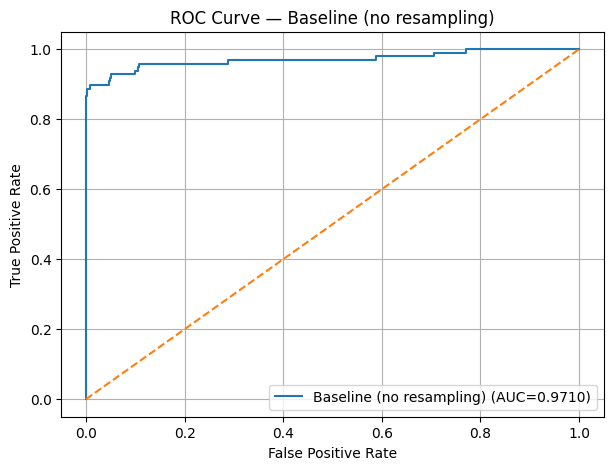

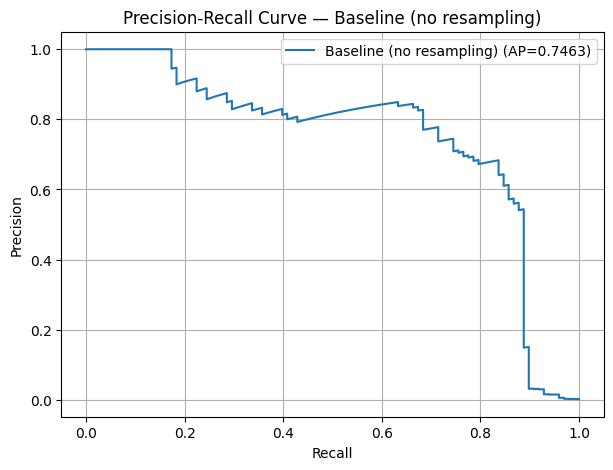

Baseline (no resampling) | ROC-AUC=0.9710 | PR-AUC(AP)=0.7463


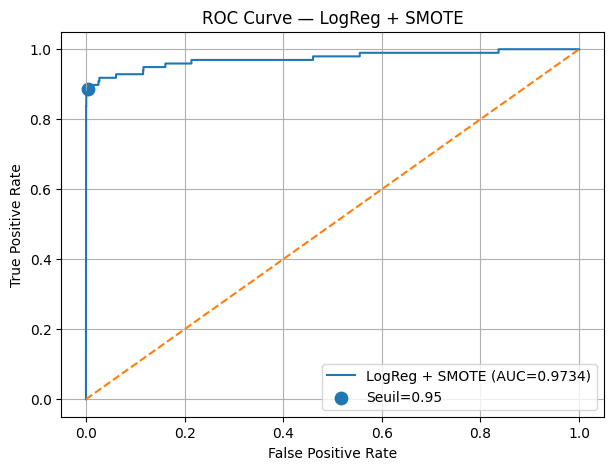

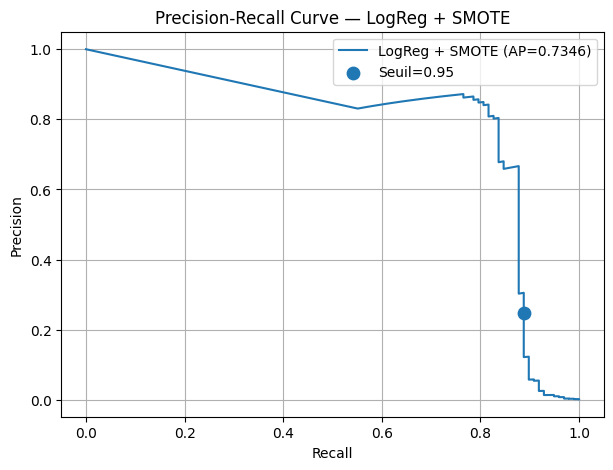

LogReg + SMOTE | ROC-AUC=0.9734 | PR-AUC(AP)=0.7346


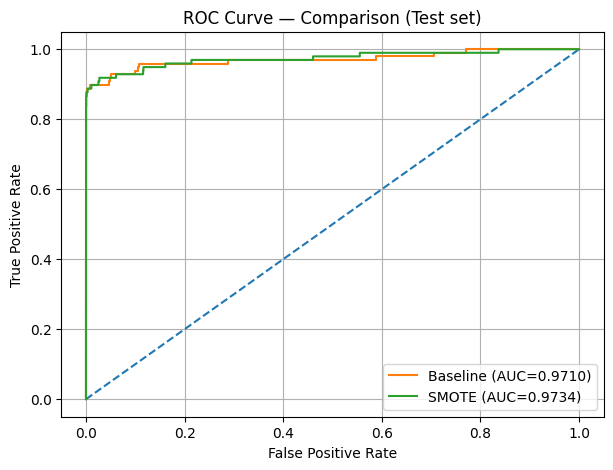

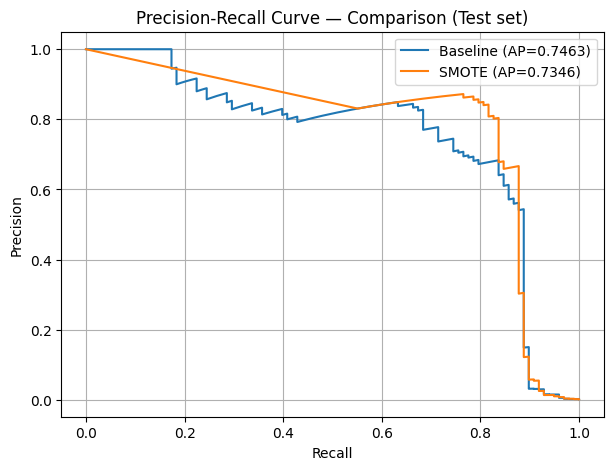

In [13]:
# === Exemples d'utilisation (à exécuter après l'entraînement des modèles) ===
# Sauvegarde des images en PNG dans le dossier courant.

# 1) Courbes pour la baseline
plot_roc_pr_curves(
    clf_base,
    X_test_ready,
    y_test,
    label="Baseline (no resampling)",
    save_prefix="baseline"
)

# 2) Courbes pour SMOTE + point du seuil 0.95 (threshold tuning)
plot_roc_pr_curves(
    clf_sm,
    X_test_ready,
    y_test,
    label="LogReg + SMOTE",
    threshold=0.95,
    save_prefix="smote_thr095"
)

# 3) Comparaison baseline vs SMOTE sur les mêmes figures
plot_compare_models_roc_pr(
    {"Baseline": clf_base, "SMOTE": clf_sm},
    X_test_ready,
    y_test,
    title_suffix="(Test set)",
    save_prefix="compare_baseline_smote"
)

## 9) Ajustement du seuil (threshold tuning)

Par défaut, la classe 1 est prédite si `proba >= 0.5`.  
En fraude, on cherche souvent :
- **plus de recall** (capturer plus de fraudes)
- en acceptant une baisse de precision (plus d’alertes)

Ici, on teste plusieurs seuils et on observe l’impact sur :
- precision(1), recall(1), f1(1)
- TP/FP/FN/TN

  On choisit ici le seuil qui **maximise F1(1)**, mais on peut aussi choisir :
- un seuil donnant un **recall minimal** (ex: ≥ 0.80),
- ou un seuil limitant les **faux positifs**.

In [14]:

def eval_thresholds(model, X_test: pd.DataFrame, y_test: pd.Series, thresholds=None) -> pd.DataFrame:
    if thresholds is None:
        thresholds = np.arange(0.1, 1.0, 0.05)

    y_proba = model.predict_proba(X_test)[:, 1]
    rows = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        rows.append({
            "threshold": t,
            "precision(1)": prec,
            "recall(1)": rec,
            "f1(1)": f1,
            "TP": tp, "FP": fp, "FN": fn, "TN": tn
        })

    return pd.DataFrame(rows).sort_values("f1(1)", ascending=False).reset_index(drop=True)

thresholds = np.arange(0.1, 1.0, 0.05)
df_thr_smote = eval_thresholds(clf_sm, X_test_ready, y_test, thresholds=thresholds)
df_thr_smote.head(10)

,threshold,precision(1),recall(1),f1(1),TP,FP,FN,TN
0,0.95,0.249284,0.887755,0.389262,87,262,11,56602
1,0.90,0.186695,0.887755,0.308511,87,379,11,56485
2,0.85,0.157324,0.887755,0.267281,87,466,11,56398
3,0.80,0.133846,0.887755,0.232620,87,563,11,56301
4,0.75,0.114583,0.897959,0.203233,88,680,10,56184
5,0.70,0.096810,0.897959,0.174777,88,821,10,56043
6,0.65,0.083333,0.897959,0.152513,88,968,10,55896
7,0.60,0.070911,0.897959,0.131441,88,1153,10,55711
8,0.55,0.060984,0.897959,0.114212,88,1355,10,55509
9,0.50,0.054315,0.918367,0.102564,90,1567,8,55297


In [15]:


best_threshold = df_thr_smote.loc[0, "threshold"]
print("Best threshold (max F1):", best_threshold)

# Probabilités (indépendantes du seuil)
y_proba_smote = clf_sm.predict_proba(X_test_ready)[:, 1]

# Scores globaux (indépendants du seuil)
roc_auc = roc_auc_score(y_test, y_proba_smote)
pr_auc = average_precision_score(y_test, y_proba_smote)
print(f"ROC-AUC (SMOTE): {roc_auc:.4f}")
print(f"PR-AUC  (SMOTE): {pr_auc:.4f}")

# Prédictions selon le seuil choisi
y_pred_best = (y_proba_smote >= best_threshold).astype(int)

print("\nClassification report (threshold tuned):")
print(classification_report(y_test, y_pred_best, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_best))


Best threshold (max F1): 0.9500000000000003
ROC-AUC (SMOTE): 0.9734
PR-AUC  (SMOTE): 0.7346

Classification report (threshold tuned):
              precision    recall  f1-score   support

           0     0.9998    0.9954    0.9976     56864
           1     0.2493    0.8878    0.3893        98

    accuracy                         0.9952     56962
   macro avg     0.6245    0.9416    0.6934     56962
weighted avg     0.9985    0.9952    0.9965     56962

Confusion matrix:
 [[56602   262]
 [   11    87]]


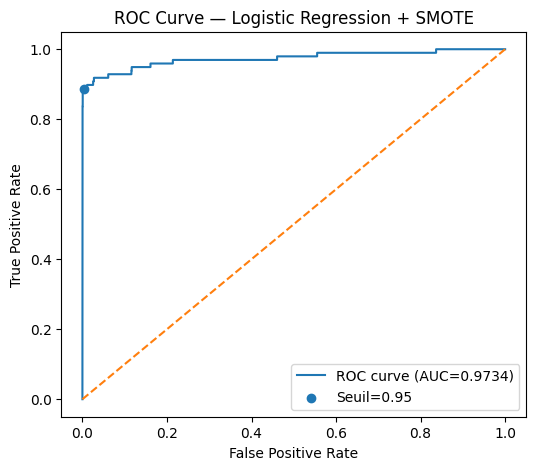

In [16]:
fpr, tpr, thr_roc = roc_curve(y_test, y_proba_smote)

# Trouver le point le plus proche du best_threshold sur la courbe
idx = np.argmin(np.abs(thr_roc - best_threshold))

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.4f})")
plt.scatter(fpr[idx], tpr[idx], label=f"Seuil={best_threshold:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression + SMOTE")
plt.legend()
plt.show()


PR-AUC (Average Precision): 0.7345690776964673


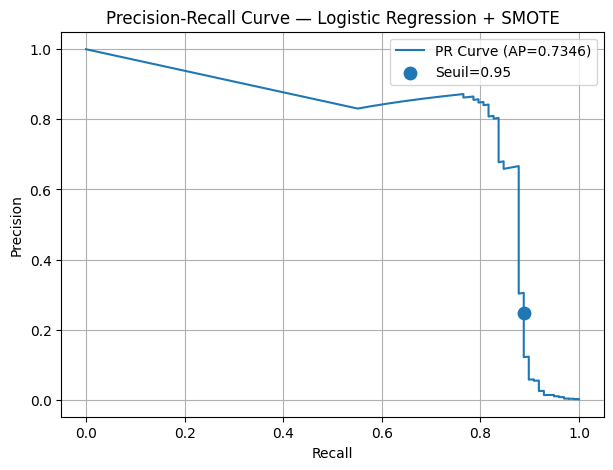

In [17]:
# Probabilités du modèle SMOTE
y_proba_smote = clf_sm.predict_proba(X_test_ready)[:, 1]

# PR-AUC
pr_auc = average_precision_score(y_test, y_proba_smote)
print("PR-AUC (Average Precision):", pr_auc)

# Courbe Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_smote)

# Seuil choisi
best_threshold = 0.95

# Trouver l'index du seuil le plus proche
idx = np.argmin(np.abs(thresholds - best_threshold))

# Attention : thresholds est de taille n-1, donc precision/recall ont 1 élément de plus
precision_point = precisions[idx]
recall_point = recalls[idx]

# Plot
plt.figure(figsize=(7,5))
plt.plot(recalls, precisions, label=f"PR Curve (AP={pr_auc:.4f})")
plt.scatter(recall_point, precision_point, s=80, label=f"Seuil={best_threshold}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — Logistic Regression + SMOTE")
plt.legend()
plt.grid(True)
plt.show()



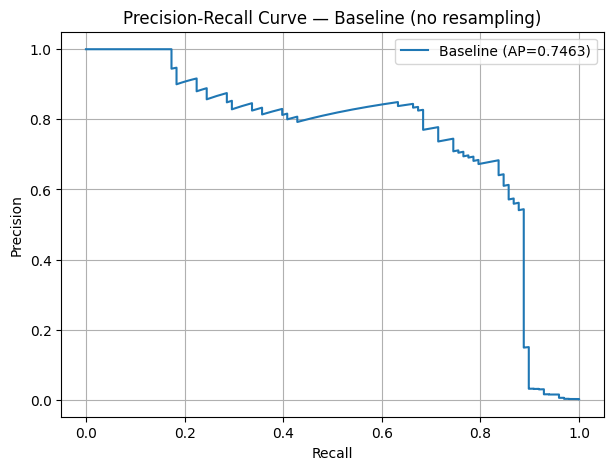

In [18]:
# PR courbe pour la baseline 

# Probabilités du modèle baseline
y_proba_base = clf_base.predict_proba(X_test_ready)[:, 1]

# PR-AUC (Average Precision)
ap_base = average_precision_score(y_test, y_proba_base)

# Courbe Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_base)

# Plot
plt.figure(figsize=(7,5))
plt.plot(recalls, precisions, label=f"Baseline (AP={ap_base:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — Baseline (no resampling)")
plt.legend()
plt.grid(True)
plt.show()


## 10) Export des datasets “prêts ML”

On exporte les jeux transformés, en rappelant :
- transformations fit sur train seulement
- test transformé avec les mêmes objets (scalers, power transformer)

In [19]:

train_out = X_train_ready.copy()
train_out["Class"] = y_train.values

test_out = X_test_ready.copy()
test_out["Class"] = y_test.values

train_out.to_csv("train_ready.csv", index=False)
test_out.to_csv("test_ready.csv", index=False)

print("Exported: train_ready.csv & test_ready.csv")

Exported: train_ready.csv & test_ready.csv


La courbe ROC montre une excellente capacité de discrimination du modèle Logistic Regression + SMOTE avec un ROC-AUC de 0.9734. Le point correspondant au seuil 0.95 se situe proche du coin supérieur gauche, indiquant un taux de détection élevé des fraudes (TPR élevé) tout en maintenant un faible taux de fausses alertes (FPR faible). Cela confirme que le seuil choisi permet un compromis adapté à un contexte bancaire où les faux positifs ont un coût opérationnel importan

## Conclusion 

Cette étude a permis de construire un pipeline complet de détection de fraude bancaire sur le dataset creditcard.csv, caractérisé par un déséquilibre extrême (≈0.17% de fraudes). Afin d’évaluer correctement les modèles dans ce contexte, les métriques ROC-AUC et surtout PR-AUC ont été utilisées, car elles sont plus adaptées aux classes rares.

Le pipeline a respecté les bonnes pratiques en évitant toute fuite de données (split train/test avant transformations). Un feature engineering métier basé sur les extrêmes de montant (Q10/Q90) a été introduit pour capter les transactions suspectes de type “test” et les montants très élevés. Les résultats montrent une excellente capacité de discrimination du modèle Logistic Regression + SMOTE, avec un ROC-AUC de 0.9734 et un PR-AUC de 0.7346.

Enfin, l’ajustement du seuil de décision a montré qu’un seuil de 0.95 améliore fortement le compromis precision/recall en réduisant les faux positifs tout en conservant un rappel élevé. Ainsi, cette étude confirme que la performance en détection de fraude dépend non seulement du modèle, mais aussi du traitement du déséquilibre et du choix du seuil adapté aux contraintes métier.